# Long Term Short Term Memory (LSTM) Neural Networks

Notes :

    - I used a serie of blog posts from "Machine Learning Mastery" to help me understand how to implement LSTM neural networks with python. The main one is there: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/. http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
    
    - I reduced the size of the original dataset in order to reduce training time. Took one year of data.  
 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
#load dataset 
df = pd.read_csv("C:/Users/julie/supervised_project/df_PS2021.csv", usecols=[1])

#Reduce dataset size. Testing data starts on the same date as in previous notebooks  
df = df.iloc[15767:24527]

#extract raw values from DataFrame 
data = df.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train = dataset[:round(len(df)*0.75)]
test = dataset[round(len(df)*0.75):]

In [3]:
def create_dataset(dataset, look_back=1):
    """
    author:
    (https://machinelearningmastery.com/
    \time-series-prediction-lstm-recurrent-neural-networks-python-keras/).
    
    This function takes a serie as input and creates X and Y datasets. 
    X is filled with lagged value of Y, lookback argument specifies the number of lag.
    
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
# reshape into X=t-24,...,t-1 and Y=t
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [5]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [6]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 17s - loss: 0.0014
Epoch 2/100
 - 17s - loss: 8.7318e-04
Epoch 3/100
 - 17s - loss: 7.2597e-04
Epoch 4/100
 - 17s - loss: 6.5654e-04
Epoch 5/100
 - 18s - loss: 6.0597e-04
Epoch 6/100
 - 17s - loss: 5.7502e-04
Epoch 7/100
 - 16s - loss: 5.6366e-04
Epoch 8/100
 - 16s - loss: 5.3841e-04
Epoch 9/100
 - 16s - loss: 5.3699e-04
Epoch 10/100
 - 17s - loss: 5.3023e-04
Epoch 11/100
 - 16s - loss: 5.0101e-04
Epoch 12/100
 - 16s - loss: 4.9888e-04
Epoch 13/100
 - 16s - loss: 4.9882e-04
Epoch 14/100
 - 16s - loss: 4.7683e-04
Epoch 15/100
 - 16s - loss: 4.9450e-04
Epoch 16/100
 - 16s - loss: 4.9296e-04
Epoch 17/100
 - 17s - loss: 4.8390e-04
Epoch 18/100
 - 17s - loss: 4.8102e-04
Epoch 19/100
 - 16s - loss: 4.7756e-04
Epoch 20/100
 - 16s - loss: 4.7844e-04
Epoch 21/100
 - 16s - loss: 4.6823e-04
Epoch 22/100
 - 16s - loss: 4.5864e-04
Epoch 23/100
 - 16s - loss: 4.7041e-04
Epoch 24/100
 - 17s - loss: 4.6779e-04
Epoch 25/100
 - 16s - loss: 4.5654e-04
Epoch 26/100
 - 16s - loss: 4.5808e-0

In [19]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)

In [21]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.85 RMSE


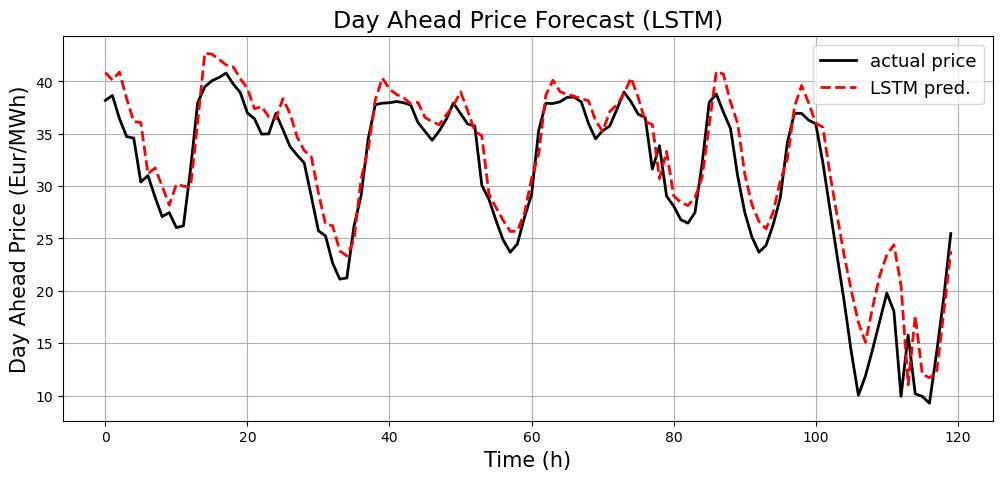

In [45]:
plt.figure(0, figsize=(12,5))
plt.plot(testY.T[:120], c='black', lw=2, label='actual price')
plt.plot(testPredict[:120], '--', c='r', lw=2, label="LSTM pred.")
plt.ylabel("Day Ahead Price (Eur/MWh)", fontsize=15)
plt.xlabel("Time (h)", fontsize=15)
plt.title("Day Ahead Price Forecast (LSTM)", fontsize=17)
plt.legend(fontsize=13)
plt.grid()
#plt.savefig("graphs/LSTM_NN_forecast.png")